# Code
---


# Imports

In [4]:
from sklearn import preprocessing, cross_validation, neighbors, naive_bayes, neural_network, svm, tree
from sklearn.metrics import confusion_matrix,  roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.decomposition import PCA
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate

# Reading Data

In [2]:
df = pd.read_csv('data/pd_speech_features.txt')
df.drop(['id'], 1, inplace=True)

In [3]:
X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

# Normalizing Data

In [4]:
Z = np.divide((X - X.mean(0)), X.std(0))

# PCA

In [5]:
pca = PCA(n_components = 168)
Z_PCA = pca.fit_transform(Z)

In [6]:
print(Z_PCA.shape)

(756, 168)


# Building the models

In [173]:
# KNN
# knn1 = neighbors.KNeighborsClassifier(n_neighbors=7)
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

# Naive Bayes
gnb = naive_bayes.GaussianNB()
gnb_bagging = BaggingClassifier(naive_bayes.GaussianNB(), max_samples = 0.5, max_features = 1.0, n_estimators = 20)

# Support Vector Machine
svmc = svm.SVC(kernel='linear', probability=True,
                     random_state=1)

# Neural Network
nn = neural_network.MLPClassifier(
#                                     activation = 'logistic', 
#                                    solver = 'sgd', 
#                                    max_iter=3000, 
#                                    learning_rate_init = 0.001, 
#                                    momentum = 0.9, 
#                                    epsilon = 1e-04, 
                                   hidden_layer_sizes = (200), 
                                   random_state = 42)
# Decision Tree
dt = tree.DecisionTreeClassifier(random_state = 42)
dt_boost = AdaBoostClassifier(random_state = 42, base_estimator=tree.DecisionTreeClassifier(random_state = 42, max_depth=1), n_estimators= 100, learning_rate = 1)
boost = AdaBoostClassifier(n_estimators= 100)
vote = VotingClassifier(estimators=[('dt', dt_boost), ('knn', knn), ('nn', nn), ('gnb', gnb)],
                          voting='soft', weights=[1, 1, 1, 1])


# Testing using cross validation

In [174]:
# model = knn
# scores = cross_validation.cross_val_score(model, Z, y, cv=5, scoring='accuracy')
# y_pred = cross_validation.cross_val_predict(model, Z, y, cv=5)

# acc = scores.mean()
# conf_mat = confusion_matrix(y, y_pred)

In [175]:
# print(acc)
# print(conf_mat)

## Accuracy, ROC/AUC, and confuson matrix

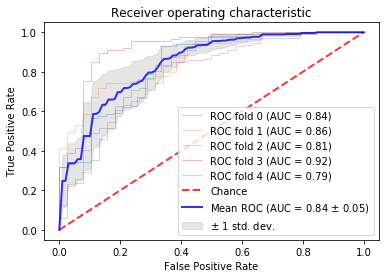

In [176]:
folds = 5
cv = StratifiedKFold(n_splits=folds)

# Classifiers: 
# Decision Tree: dt
# Decision Tree (with boosting): dt_boost
# MLP: nn
# Gaussian Naive Bayes: gnb
# KNN: knn

classifier = nn
inp = Z

acc = np.zeros(folds)
confm = np.zeros((2, 2))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(inp, y):
    probas_ = classifier.fit(inp[train], y[train]).predict_proba(inp[test])
    # Compute accuracy
    y_pred = classifier.predict(inp[test])
    acc[i] = (y_pred == y[test]).mean()
    # Confusion matrix
    confm = confm + confusion_matrix(y[test], y_pred)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [177]:
'{:.2f}% +- {:.2f}%'.format(acc.mean() * 100, acc.std() * 100) 

'80.04% +- 6.39%'

In [178]:
cm = np.zeros((3,3))

In [179]:
cm[0:2, 0:2] = confm
cm[0,2] = (cm[0,0] / cm[0,0:2].sum())* 100
cm[1,2] = (cm[1,1] / cm[1,0:2].sum())* 100
cm[2,0] = (cm[0,0] / cm[0:2,0].sum())* 100
cm[2,1] = (cm[1,1] / cm[0:2,1].sum())* 100

In [180]:
display(HTML(tabulate.tabulate(cm, tablefmt='html')))

122,70,63.5417
81,483,85.6383
60.0985,87.3418,0
